In [1]:
%reload_ext autoreload
%autoreload 2

## Imports

In [2]:
import sys

In [3]:
sys.path.append("..")

In [4]:
import pandas as pd

In [5]:
import matplotlib.pyplot as plt

In [6]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import WeightedRandomSampler

In [7]:
from lib.dataset import HAM10000, create_train_val_split, read_meta_data

## Folders

In [8]:
DATA_FOLDER = "../data"
# ANNOTATION_FILE_NAME = "HAM10000_metadata.csv"
LABEL_COLUMN = 'dx'

## Main

In [9]:
# Get training ids and validation ids
train_ids, val_ids = create_train_val_split(DATA_FOLDER, 0.8, 0.2)

In [10]:
print("Samples in training set: {}".format(len(train_ids)))
print("Samples in validation set: {}".format(len(val_ids)))

n_samples_total = len(val_ids) + len(train_ids)

print("Total samples: {}".format(n_samples_total))

# Sanity checks: union must be equal to total, intersection must be 0
assert (len(set(val_ids).union(set(train_ids))) == n_samples_total)
assert (len(set(val_ids).intersection(set(train_ids))) == 0)

Samples in training set: 8010
Samples in validation set: 2005
Total samples: 10015


### Plot distributions in sets

In [11]:
data_df = read_meta_data(DATA_FOLDER)

data_train = data_df.loc[train_ids]
data_val = data_df.loc[val_ids]

#### Training set

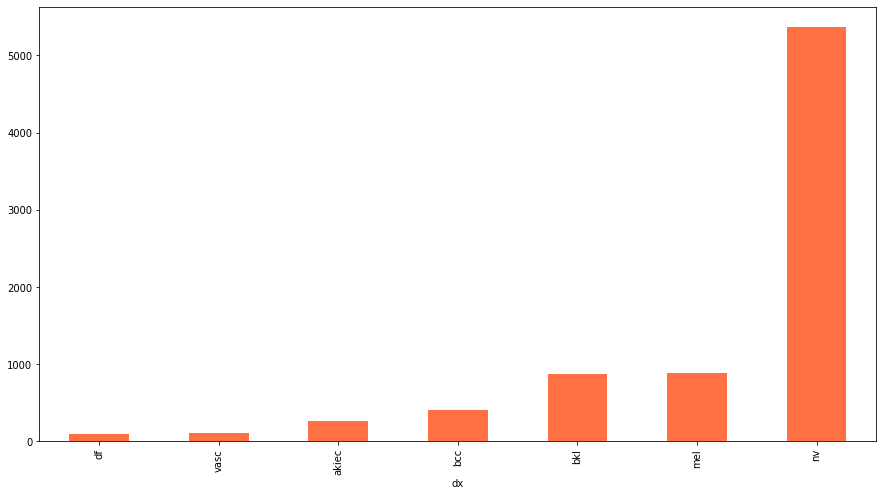

In [12]:
plt.figure(figsize=(15,8))
data_train.groupby(LABEL_COLUMN).count()['sex'].sort_values().plot(kind='bar', color="#ff7043")

#### Validation set

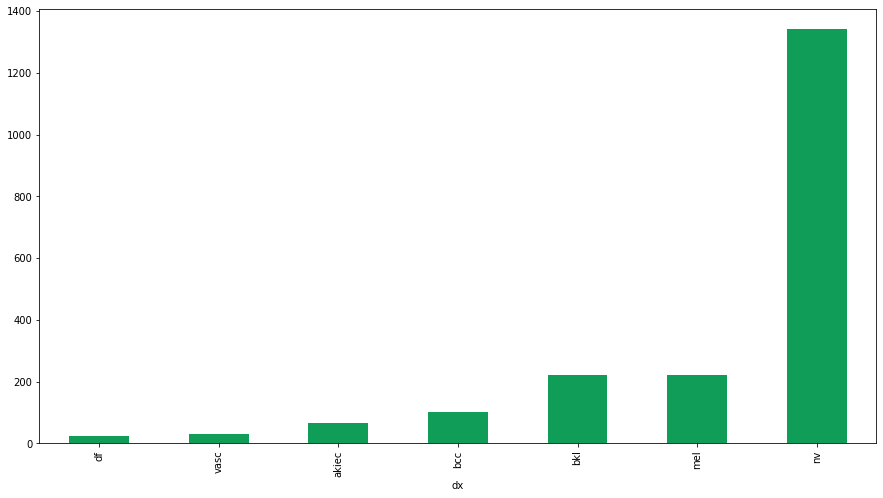

In [13]:
plt.figure(figsize=(15,8))
data_val.groupby(LABEL_COLUMN).count()['sex'].sort_values().plot(kind='bar', color='#0f9d58')

In [14]:
dataset_train = HAM10000(DATA_FOLDER, train_ids)
dataset_val = HAM10000(DATA_FOLDER, val_ids)

In [15]:
data_train

,lesion_id,dx,dx_type,age,sex,localization
image_id,,,,,,
ISIC_0031929,HAM_0001499,akiec,histo,65.0,male,lower extremity
ISIC_0030785,HAM_0004609,akiec,histo,75.0,male,back
ISIC_0028816,HAM_0003123,akiec,histo,60.0,male,face
ISIC_0025790,HAM_0001004,akiec,histo,75.0,female,lower extremity
ISIC_0026702,HAM_0005228,akiec,histo,80.0,female,face
...,...,...,...,...,...,...
ISIC_0028885,HAM_0005427,vasc,consensus,75.0,male,back
ISIC_0027856,HAM_0007118,vasc,consensus,45.0,female,trunk
ISIC_0025452,HAM_0004257,vasc,consensus,55.0,female,abdomen


### Data loading

In [16]:
weights = dataset_val.make_weights_for_balanced_classes()

In [17]:
dataset_val._weight_per_class

[30.37878787878788,
 19.466019417475728,
 9.113636363636363,
 87.17391304347827,
 8.991031390134529,
 1.4951528709917972,
 69.13793103448276]

In [18]:
BATCH_SIZE = 4

In [19]:
sampler = WeightedRandomSampler(weights, len(weights))

dataloader_val = DataLoader(dataset_val, BATCH_SIZE, sampler=sampler, num_workers=4)

In [20]:
from tqdm import tqdm

In [21]:
i = 0

# Initialize list for keeping track of counts
counts = [0] * 7

# SAMPLE_ITERATIONS = 100
SAMPLE_ITERATIONS = len(dataloader_val) // BATCH_SIZE

for data, target in tqdm(dataloader_val, total=SAMPLE_ITERATIONS):
    
#     if i >= SAMPLE_ITERATIONS:
#         break
        
    for c in target:
        counts[c] += 1
    
    i += 1

502it [00:05, 96.28it/s]                         


In [22]:
for i, c in enumerate(dataset_val.get_class_map_dict()):
    print("# of samples for class {}:\t{}".format(c, counts[i]))

# of samples for class akiec:	269
# of samples for class bcc:	286
# of samples for class bkl:	302
# of samples for class df:	302
# of samples for class mel:	267
# of samples for class nv:	283
# of samples for class vasc:	296


In [23]:
# Sanity check on results
# Not necessarily true
# assert(sum(counts) == BATCH_SIZE * SAMPLE_ITERATIONS)

In [24]:
print(sum(counts))
print(len(dataset_val))

2005
2005


### Input image normalization

In [25]:
loader = DataLoader(
    dataset_train,
    batch_size=10,
    num_workers=8,
    shuffle=False
)

mean = 0.
std = 0.
nb_samples = 0.
for data, _ in tqdm(loader):
#     print(data.size())
    
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples
#     break

mean /= nb_samples
std /= nb_samples

print("Mean: {}".format(mean))
print("Std: {}".format(std))

100%|██████████| 801/801 [00:28<00:00, 27.66it/s]

Mean: tensor([0.7633, 0.5459, 0.5704])
Std: tensor([0.0898, 0.1184, 0.1331])


### Visualize augmentations

In [26]:
import torchvision.transforms as transforms
import PIL

In [27]:
level = 2

In [36]:
sys.path.append("..")
from main import get_data_augmentation_transforms

In [37]:
da_transforms = get_data_augmentation_transforms(4)

# Add ToPilImage for plotting
da_transforms = transforms.Compose([da_transforms, transforms.ToPILImage()]) 

In [38]:
dataset_train = HAM10000(DATA_FOLDER, train_ids, da_transforms)

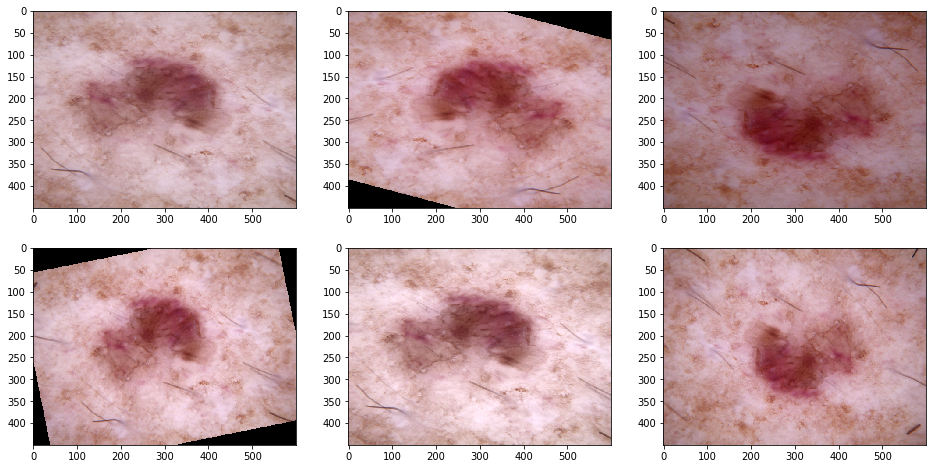

In [39]:
# Creates two subplots and unpacks the output array immediately
n_rows = 2
n_cols = 3
# plt.figure()
f, axes = plt.subplots(n_rows, n_cols, figsize=(16,8))
for ii in range(n_rows * n_cols):
    x = ii // n_cols
    y = ii % n_cols
#     print(x, y)
    img, _ = dataset_train[0]
    axes[x, y].imshow(img)
# ax1.plot(x, y)
# ax1.set_title('Sharing Y axis')
# ax2.scatter(x, y)

